In [178]:
import tensorflow as tf
import scipy.io 
import matplotlib.pyplot as plt
import cv2
import keras
from glob import glob
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd
import cv2

from sklearn.model_selection import KFold
# from keras.preprocessing.image import ImageDataGenerator

# import keras_metrics

from keras.applications import mobilenet, resnet50 #, vgg16, inception_v3, resnet50, 
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, History

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import logging
# logging.getLogger().setLevel(logging.DEBUG)


import seaborn
seaborn.set_style("darkgrid")

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [2]:
keras.__version__

'2.1.5'

## Params

In [3]:
all_data_dir = 'E:\\Work/PathoBarIlan/Shlomi2018/'# '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018'
is_relative_path_csv = False
seed = 4221

pos_name_init = 'Cancer'
neg_name_init = 'Normal'

use_rgb = False # True=rgb, False=spectral
if use_rgb:
    file_ext = '.png'
else:
    file_ext = '.npy'
    
window_size = (200, 200)
shift = (100, 100)

In [4]:
w,h = window_size
if use_rgb:
    input_shape = (w,h,3)
else:
    input_shape = (w,h,40)
batch_size = 16

## utils

In [5]:
def read_slide(path):
    mat = scipy.io.loadmat(path)
    spectral = mat["Spec"]
    rgb = mat["Section"]
    shape = rgb.shape
    
    return spectral, rgb

In [6]:
def create_batch_of_crops_from_slide(img, window_size, shift, vis_flag=False):
    crops = []

    n_iter_x = (img.shape[1]-window_size[0])//shift[0] + 1

    n_iter_y = (img.shape[0]-window_size[1])//shift[1] + 1

#     n_iter_x, n_iter_y

    for i in range(n_iter_x):
        for j in range(n_iter_y):
            init_y = i*shift[0]
            init_x = j*shift[1]
        
            crops.append(img[init_x:init_x+window_size[0], init_y:init_y+window_size[1], :])
    if vis_flag:
        visualize_batch_of_crops(crops, n_iter_y, n_iter_x)
    return crops

In [7]:
def visualize_batch_of_crops(crops, n_iter_y, n_iter_x):
    fig, axes = plt.subplots(n_iter_y, n_iter_x, figsize=(5, 5), gridspec_kw = {'wspace':0, 'hspace':0})

    for i in range(n_iter_x):
        for j in range(n_iter_y):
            axes[j, i].imshow(crops[i*n_iter_y + j])
            axes[j, i].axis('off')
            axes[j, i].set_aspect('equal')
    plt.show()

In [8]:
def create_crops_from_fileslist(fileslist, window_size, shift):
    rgb_crops = []
    spectral_crops = []
    labels = []

    for file in tqdm(fileslist):
#         file_name = os.path.basename(file)
#         print('Saving crops for file {} ...'.format(file_name))
#         print(file)
        spectral, rgb = read_slide(file)
        spectral_crops = create_batch_of_crops_from_slide(spectral, window_size=window_size, shift=shift)
        rgb_crops = create_batch_of_crops_from_slide(rgb, window_size=window_size, shift=shift)
        save_dir = file.replace('.mat', '_win{}-{}_shift{}-{}'.format(window_size[0], window_size[1], shift[0], shift[1]))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for idx, (im_np, spec_np) in enumerate(zip(rgb_crops, spectral_crops)):
            im = Image.fromarray(im_np)
            im.save(os.path.join(save_dir, '{:05}.png'.format(idx)))
            np.save(os.path.join(save_dir, '{:05}.npy'.format(idx)), spec_np)


In [9]:
def create_crops_from_dir(dir_path, window_size, shift):
    print('Saving crops for slides in dir: {}'.format(dir_path))
    fileslist = glob(dir_path + '/*.mat')
    create_crops_from_fileslist(fileslist, window_size, shift)

In [10]:
def create_csv_for_folder(data_dir, ext):
    if ext[0] == '.':
        ext = ext[1:]
    data_df = pd.DataFrame(columns=['filename', 'label'])
    files = glob(os.path.join(data_dir,'*', '*.{}'.format(ext)))
    files = [file for file in files if "Mixed" not in file]
#     print(data_dir+'/*/*.{}'.format(ext))
    
    init_len = len(data_dir)
    delete_folder = all_data_dir
    if not is_relative_path_csv:
        delete_folder = '/'
    if not delete_folder[-1] == '/':
        delete_folder += '/'
    files = [file.replace(delete_folder, '/') for file in files]
#     print(files)
    labels = [1 if pos_name_init in file else 0 for file in files]
#     print(labels)
    data_df['filename'] = files
    data_df['label'] = labels
#     data_df.to_csv(os.path.join(data_dir, os.path.basename(data_dir)+'.csv'), index=False)
#     print('Created CSV successfully for folder {}'.format(data_dir))
    
    return data_df    

In [11]:
slides = glob(os.path.join(all_data_dir, "*/"))
slides

['E:\\Work/PathoBarIlan/Shlomi2018\\Case10\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case11\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case12\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case14\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case16\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case16b\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case17\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case18\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case19484\\',
 'E:\\Work/PathoBarIlan/Shlomi2018\\Case8\\']

In [12]:
skf = KFold(n_splits=5, shuffle=True, random_state=seed)

train_slides_all = []
test_slides_all = []
val_slides_all = []

for train_index, test_index in skf.split(np.arange(len(slides)).T, np.arange(len(slides)).T):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_slides_all.append(train_index)
    val_slides_all.append([test_index[0]])
    test_slides_all.append([test_index[1]])

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 2 3 5 7 8 9] TEST: [4 6]
TRAIN: [0 1 3 4 5 6 7 8] TEST: [2 9]
TRAIN: [0 1 2 4 6 7 8 9] TEST: [3 5]
TRAIN: [0 1 2 3 4 5 6 9] TEST: [7 8]


In [13]:
i = 3 # take one of the K-Folds

train_index = train_slides_all[i]
val_index = val_slides_all[i]
test_index = test_slides_all[i]

train_index, val_index, test_index

(array([0, 1, 2, 4, 6, 7, 8, 9]), [3], [5])

In [14]:
def get_dfs_for_indices(slides, index_list):
    dfs = []
    for slide in np.array(slides)[index_list]:
        data_dir = slide
        dfs.append(create_csv_for_folder(data_dir, file_ext))
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1, random_state=seed)  # frac=1 is same as shuffling df.
    return df

In [15]:
df_train = get_dfs_for_indices(slides, train_index)
df_test = get_dfs_for_indices(slides, test_index)
df_val = get_dfs_for_indices(slides, val_index)

In [16]:
pd.options.display.max_colwidth = 150

In [17]:
print(len(df_train.index.values))
print(len(set(df_train.index.values)))

print(len(df_train.columns.values))
print(len(set(df_train.columns.values)))

2991
2991
2
2


In [18]:
assert len(set(df_train.label.values)) == 2 and len(set(df_val.label.values)) == 2 and len(set(df_test.label.values)) == 2  

In [19]:
def sample_norm(x):
#     print("x.shape:", x.shape)
    maxi = x.max(axis=1).max(axis=1)
#     print("maxi.shape:", maxi.shape)
    maxi = np.repeat(maxi[:, np.newaxis, : ], window_size[0], axis=1)
    maxi = np.repeat(maxi[:, np.newaxis, : ], window_size[1], axis=1)
    return x/maxi


def generator_from_df(df, batch_size, shuffle=True): 
    
    n_batches = df.shape[0]//batch_size
    while True:
        if shuffle:
            df_tmp = df.copy().sample(frac=1)  # frac=1 is same as shuffling df.
        else:
            df_tmp = df
        
        for i in range(n_batches):
            sub = df_tmp.iloc[batch_size*i:batch_size*(i+1)]
            if use_rgb:
                X = [img_to_array(load_img(f, target_size=input_shape)) for f in sub.filename]
            else:
                X = [np.load(f) for f in sub.filename]
                
            X = sample_norm(np.stack(X))
            logging.debug(f"from file {sub.iloc[0].filename}\nto file {sub.iloc[-1].filename}")

            Y = sub.label.values
            Y = to_categorical(Y, num_classes=2)
            # Simple model, one input, one output.
            
            yield X, Y

####### copying generator_from_df:
https://gist.github.com/timehaven/257eef5b0e2d9e2625a9eb812ca2226b#file-akmtdfgen-py

In [20]:
train_generator = generator_from_df(df_train, batch_size)
val_generator = generator_from_df(df_val, batch_size)
test_generator = generator_from_df(df_test, batch_size, shuffle=False)

In [21]:
# input_shape = train_generator.image_shape
mobilenet_model = mobilenet.MobileNet(include_top=True, weights=None, input_shape=input_shape, classes=2, dropout=0.2)
# mobilenet_model = resnet50.ResNet50(include_top=True, weights=None, input_shape=input_shape, classes=2)

C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\keras\applications\imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 40 input channels.
  str(input_shape[-1]) + ' input channels.')


In [22]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 40)      0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 202, 202, 40)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      11520     
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 102, 102, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
__________

_________________________________________________________________
conv_pad_9 (ZeroPadding2D)   (None, 15, 15, 512)       0         
_________________________________________________________________
conv_dw_9 (DepthwiseConv2D)  (None, 13, 13, 512)       4608      
_________________________________________________________________
conv_dw_9_bn (BatchNormaliza (None, 13, 13, 512)       2048      
_________________________________________________________________
conv_dw_9_relu (Activation)  (None, 13, 13, 512)       0         
_________________________________________________________________
conv_pw_9 (Conv2D)           (None, 13, 13, 512)       262144    
_________________________________________________________________
conv_pw_9_bn (BatchNormaliza (None, 13, 13, 512)       2048      
_________________________________________________________________
conv_pw_9_relu (Activation)  (None, 13, 13, 512)       0         
_________________________________________________________________
conv_pad_1

In [23]:
optimizer = Adam(lr=1e-2) # 1e-3
mobilenet_model.compile(loss="binary_crossentropy", optimizer=optimizer) #  binary_crossentropy , categorical_crossentropy
# history = History()
lrReduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-6)
if use_rgb:
    chkpnt = ModelCheckpoint("my_models/model_rgb_weights_epoch{epoch:02d}-val_loss{val_loss:.3f}.hdf5", save_best_only=True) # -train_loss{history.History()[loss][-1]:.2f}
else:
    chkpnt = ModelCheckpoint("my_models/model_spec_weights_epoch{epoch:02d}-val_loss{val_loss:.3f}.hdf5", save_best_only=True) # -train_loss{history.History()[loss][-1]:.2f}
num_of_epochs = 100

In [24]:
STEP_SIZE_TRAIN=len(df_train)//batch_size
STEP_SIZE_VALID=len(df_val)//batch_size
# print(STEP_SIZE_VALID)
history = mobilenet_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_of_epochs, callbacks=[lrReduce, chkpnt], shuffle=False) # chkpnt

Epoch 1/100
186/186 [==============================] - ETA: 28:47 - loss: 0.76 - ETA: 15:13 - loss: 1.20 - ETA: 10:41 - loss: 1.05 - ETA: 8:25 - loss: 0.7950 - ETA: 8:17 - loss: 1.056 - ETA: 8:16 - loss: 0.994 - ETA: 8:14 - loss: 0.973 - ETA: 8:12 - loss: 0.910 - ETA: 8:06 - loss: 0.846 - ETA: 8:02 - loss: 0.788 - ETA: 7:58 - loss: 0.732 - ETA: 7:53 - loss: 0.685 - ETA: 7:52 - loss: 0.634 - ETA: 7:49 - loss: 0.619 - ETA: 7:49 - loss: 0.601 - ETA: 7:44 - loss: 0.565 - ETA: 7:43 - loss: 0.551 - ETA: 7:39 - loss: 0.584 - ETA: 7:36 - loss: 0.567 - ETA: 7:32 - loss: 0.540 - ETA: 7:30 - loss: 0.536 - ETA: 7:28 - loss: 0.525 - ETA: 7:24 - loss: 0.554 - ETA: 7:23 - loss: 0.571 - ETA: 7:21 - loss: 0.564 - ETA: 7:18 - loss: 0.556 - ETA: 7:16 - loss: 0.545 - ETA: 7:14 - loss: 0.529 - ETA: 7:12 - loss: 0.527 - ETA: 7:10 - loss: 0.518 - ETA: 7:06 - loss: 0.504 - ETA: 7:04 - loss: 0.493 - ETA: 7:02 - loss: 0.490 - ETA: 7:00 - loss: 0.480 - ETA: 6:58 - loss: 0.470 - ETA: 6:55 - loss: 0.459 - ETA: 6:5

186/186 [==============================] - ETA: 1:47 - loss: 0.309 - ETA: 1:46 - loss: 0.187 - ETA: 1:47 - loss: 0.135 - ETA: 1:46 - loss: 0.109 - ETA: 1:45 - loss: 0.126 - ETA: 1:45 - loss: 0.149 - ETA: 1:45 - loss: 0.136 - ETA: 1:44 - loss: 0.121 - ETA: 1:43 - loss: 0.113 - ETA: 1:43 - loss: 0.103 - ETA: 1:42 - loss: 0.096 - ETA: 1:41 - loss: 0.093 - ETA: 2:03 - loss: 0.105 - ETA: 2:25 - loss: 0.098 - ETA: 2:48 - loss: 0.095 - ETA: 3:08 - loss: 0.099 - ETA: 3:24 - loss: 0.094 - ETA: 3:40 - loss: 0.090 - ETA: 3:54 - loss: 0.096 - ETA: 4:03 - loss: 0.093 - ETA: 4:14 - loss: 0.089 - ETA: 4:23 - loss: 0.087 - ETA: 4:31 - loss: 0.083 - ETA: 4:37 - loss: 0.082 - ETA: 4:43 - loss: 0.082 - ETA: 4:49 - loss: 0.079 - ETA: 4:55 - loss: 0.077 - ETA: 5:00 - loss: 0.074 - ETA: 5:03 - loss: 0.072 - ETA: 5:07 - loss: 0.069 - ETA: 5:10 - loss: 0.067 - ETA: 5:12 - loss: 0.072 - ETA: 5:14 - loss: 0.070 - ETA: 5:16 - loss: 0.073 - ETA: 5:18 - loss: 0.071 - ETA: 5:19 - loss: 0.069 - ETA: 5:21 - loss: 0.0

186/186 [==============================] - ETA: 1:45 - loss: 0.003 - ETA: 1:45 - loss: 0.016 - ETA: 1:45 - loss: 0.058 - ETA: 1:45 - loss: 0.050 - ETA: 1:44 - loss: 0.041 - ETA: 1:45 - loss: 0.034 - ETA: 1:44 - loss: 0.030 - ETA: 1:43 - loss: 0.047 - ETA: 1:43 - loss: 0.042 - ETA: 1:43 - loss: 0.060 - ETA: 1:42 - loss: 0.064 - ETA: 1:42 - loss: 0.065 - ETA: 2:02 - loss: 0.070 - ETA: 2:29 - loss: 0.067 - ETA: 2:51 - loss: 0.064 - ETA: 3:10 - loss: 0.060 - ETA: 3:25 - loss: 0.060 - ETA: 3:38 - loss: 0.057 - ETA: 3:52 - loss: 0.061 - ETA: 4:02 - loss: 0.058 - ETA: 4:12 - loss: 0.055 - ETA: 4:21 - loss: 0.053 - ETA: 4:31 - loss: 0.051 - ETA: 4:39 - loss: 0.049 - ETA: 4:44 - loss: 0.048 - ETA: 4:50 - loss: 0.056 - ETA: 4:54 - loss: 0.062 - ETA: 4:59 - loss: 0.060 - ETA: 5:03 - loss: 0.061 - ETA: 5:07 - loss: 0.062 - ETA: 5:10 - loss: 0.068 - ETA: 5:12 - loss: 0.067 - ETA: 5:15 - loss: 0.071 - ETA: 5:17 - loss: 0.088 - ETA: 5:19 - loss: 0.086 - ETA: 5:20 - loss: 0.110 - ETA: 5:21 - loss: 0.1

186/186 [==============================] - ETA: 1:47 - loss: 0.001 - ETA: 1:47 - loss: 0.002 - ETA: 1:46 - loss: 0.002 - ETA: 1:45 - loss: 0.008 - ETA: 1:44 - loss: 0.010 - ETA: 1:44 - loss: 0.026 - ETA: 1:43 - loss: 0.024 - ETA: 1:42 - loss: 0.039 - ETA: 1:44 - loss: 0.034 - ETA: 1:43 - loss: 0.067 - ETA: 1:42 - loss: 0.067 - ETA: 1:42 - loss: 0.062 - ETA: 1:58 - loss: 0.058 - ETA: 2:24 - loss: 0.065 - ETA: 2:45 - loss: 0.067 - ETA: 3:05 - loss: 0.064 - ETA: 3:20 - loss: 0.061 - ETA: 3:35 - loss: 0.070 - ETA: 3:48 - loss: 0.068 - ETA: 4:01 - loss: 0.072 - ETA: 4:11 - loss: 0.070 - ETA: 4:21 - loss: 0.067 - ETA: 4:27 - loss: 0.064 - ETA: 4:34 - loss: 0.061 - ETA: 4:41 - loss: 0.065 - ETA: 4:46 - loss: 0.063 - ETA: 4:52 - loss: 0.064 - ETA: 4:56 - loss: 0.065 - ETA: 4:59 - loss: 0.064 - ETA: 5:03 - loss: 0.062 - ETA: 5:06 - loss: 0.061 - ETA: 5:09 - loss: 0.060 - ETA: 5:11 - loss: 0.060 - ETA: 5:13 - loss: 0.059 - ETA: 5:15 - loss: 0.057 - ETA: 5:17 - loss: 0.058 - ETA: 5:18 - loss: 0.0

186/186 [==============================] - ETA: 2:12 - loss: 0.009 - ETA: 2:04 - loss: 0.054 - ETA: 2:03 - loss: 0.036 - ETA: 2:02 - loss: 0.036 - ETA: 2:03 - loss: 0.029 - ETA: 2:01 - loss: 0.024 - ETA: 2:00 - loss: 0.021 - ETA: 1:59 - loss: 0.018 - ETA: 2:01 - loss: 0.016 - ETA: 2:01 - loss: 0.021 - ETA: 2:00 - loss: 0.020 - ETA: 1:59 - loss: 0.018 - ETA: 2:16 - loss: 0.017 - ETA: 2:45 - loss: 0.016 - ETA: 3:09 - loss: 0.015 - ETA: 3:33 - loss: 0.015 - ETA: 3:51 - loss: 0.027 - ETA: 4:06 - loss: 0.027 - ETA: 4:21 - loss: 0.026 - ETA: 4:35 - loss: 0.025 - ETA: 4:45 - loss: 0.024 - ETA: 4:55 - loss: 0.023 - ETA: 5:04 - loss: 0.138 - ETA: 5:12 - loss: 0.132 - ETA: 5:20 - loss: 0.147 - ETA: 5:26 - loss: 0.146 - ETA: 5:33 - loss: 0.143 - ETA: 5:38 - loss: 0.158 - ETA: 5:42 - loss: 0.153 - ETA: 5:46 - loss: 0.149 - ETA: 5:50 - loss: 0.147 - ETA: 5:53 - loss: 0.143 - ETA: 5:56 - loss: 0.141 - ETA: 5:58 - loss: 0.138 - ETA: 5:59 - loss: 0.135 - ETA: 6:01 - loss: 0.137 - ETA: 6:02 - loss: 0.1

KeyboardInterrupt: 

In [25]:
x, y = next(test_generator)
y_proba = mobilenet_model.predict(x)
# mobilenet_model.predict(next())

In [26]:
print(y)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [27]:
mobilenet_model.evaluate(x, y)

16/16 [==============================] - 0s 30ms/step


5.113702297210693

In [28]:
y_proba.argmax(axis=1)==y.argmax(axis=1)

array([ True, False,  True,  True, False,  True, False, False, False,
        True,  True,  True, False,  True, False,  True])

In [ ]:
# STEP_SIZE_TEST=len(df_test)//batch_size
# mobilenet_model.evaluate_generator(train_generator, steps=1)
mobilenet_model.evaluate(xxx, yyy)

In [ ]:
# y_pred = mobilenet_model.predict_generator(train_generator, steps=1)
y_pred = mobilenet_model.predict(xx)
y_pred

In [ ]:
y_pred.argmax(axis=1), y_train.values[:, 1].astype(int)

In [29]:
y_test = df_test['label'][:len(y_pred)].values

NameError: name 'y_pred' is not defined

In [ ]:
plot_roc_curve(y_test, y_pred)
plt.show()

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

In [ ]:
y_pred.sum()

In [ ]:
y_test.sum()

In [ ]:
(y_pred==y_test).sum()/220

### plot roc curve

In [169]:
def plot_roc_curve(y_true, y_scores, figsize=(15, 8)):
    fpr, tpr, threshold = roc_curve(y_true, y_scores)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axes()

    return fpr, tpr, threshold

In [182]:
def plot_precision_recall_curve(y_true, y_scores, figsize=(15, 8)):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=figsize)
    plt.plot(precision, recall)
#     plt.plot([0, 1], [0, 1], "k--")
    plt.axes()
    
    return precision, recall, thresholds

In [140]:
mobilenet_model.load_weights("my_models/model_spec_weights_epoch36-val_loss0.006-train_loss0.004.hdf5")

In [161]:
y_tests = []
y_preds = []
for i in range(len(df_test)//batch_size):
    x, y = next(test_generator)
    print(mobilenet_model.evaluate(x, y))
    y_tests.append(y.argmax(axis=1))
    y_preds.append(mobilenet_model.predict(x)[:,1])

16/16 [==============================] - 1s 47ms/step
0.0216115340590477
16/16 [==============================] - 0s 24ms/step
0.1286105364561081
16/16 [==============================] - 0s 23ms/step
0.4877246916294098
16/16 [==============================] - 0s 24ms/step
0.05335381254553795
16/16 [==============================] - 0s 20ms/step
0.092352494597435
16/16 [==============================] - 0s 21ms/step
0.052028391510248184
16/16 [==============================] - 0s 23ms/step
0.2594195008277893
16/16 [==============================] - 0s 21ms/step
0.18670204281806946
16/16 [==============================] - 0s 21ms/step
0.07823367416858673
16/16 [==============================] - 0s 21ms/step
0.08550003916025162
16/16 [==============================] - 0s 22ms/step
0.30864691734313965
16/16 [==============================] - 0s 21ms/step
0.08360651135444641
16/16 [==============================] - 0s 21ms/step
0.3477115333080292


In [163]:
y_test = np.stack(y_tests)
y_pred = np.stack(y_preds)

y_test = y_test.reshape((-1, 1))
y_pred = y_pred.reshape((-1, 1))

1.0


C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


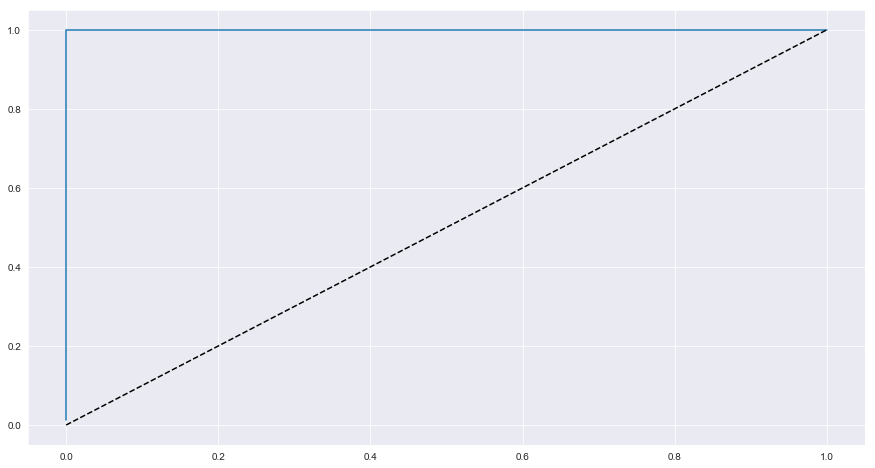

In [180]:
print(roc_auc_score(y_test, y_pred))
fpr, tpr, threshold = plot_roc_curve(y_test, y_pred, figsize=(15, 8))

In [ ]:
precision, recall, threshold = plot_precision_recall_curve(y_test, y_pred, figsize=(15, 8))

In [131]:
STEP_SIZE_TEST=len(df_test)//batch_size
y_proba_test = mobilenet_model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [132]:
# y_test = to_categorical(df_test.iloc[:y_proba_test.shape[0]].label.values, num_classes=2)
y_test = df_test['label'][:len(y_proba_test)].values

In [138]:
y_test

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [137]:
y_proba_test.argmax(axis=1)

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [125]:
# y_test = y_test[:, 1]
y_test = y_test.reshape((-1, 1))
y_proba_test = y_proba_test[:, 1].reshape((-1, 1))

In [126]:
from scikitplot.metrics import plot_roc

In [127]:
from sklearn.metrics import roc_curve

1